In [1]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import utils
import plotter

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

import cmasher as cmr

In [2]:
ctopmany = '#33BBEE'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

In [3]:
def load_data(cat_tag, cf_tag, Nrealizations=100):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    n_converged = 0

    for Nr in range(Nrealizations):

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
            r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
        
        rs.append(r_avg)
        xis.append(xi)

    return rs, xis

In [4]:
def load_true(cat_tag):
    cat_dir = '../catalogs'
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2
    return r_true, xi_true

### Check out the 3e-4 number density mock

First the truth:

True r_peak: 100.0


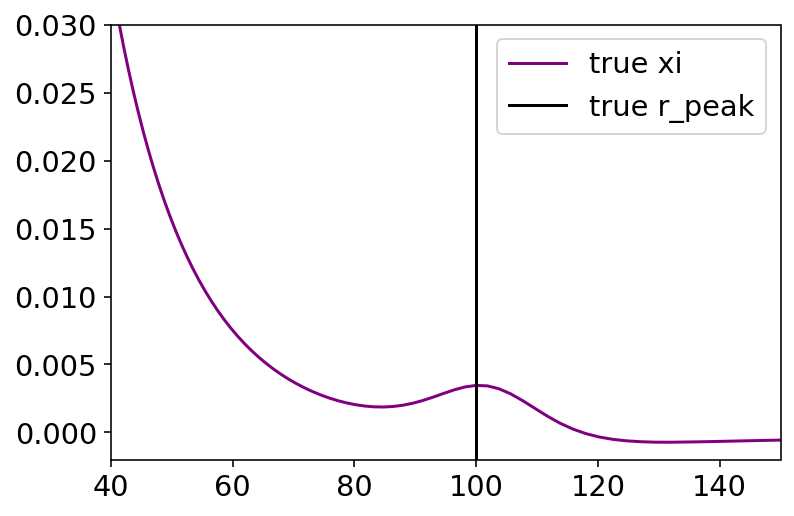

In [5]:
region = (85, 115)
cat_tag = '_L750_n3e-4'
r_true, xi_true = load_true(cat_tag)
peak_region_true = np.array([(r_true[i], xi_true[i]) for i in range(len(r_true)) if region[0]<r_true[i]<region[1]])
i_max_true = np.argmax(peak_region_true[:,1])
r_max_true = peak_region_true[i_max_true][0]
print("True r_peak:", r_max_true)

plt.figure()
plt.plot(r_true, xi_true, color='purple', label=f'true xi')
plt.axvline(r_max_true, color='k', label='true r_peak')
plt.xlim(40, 150)
plt.ylim(-0.002, 0.03)
plt.legend()

In [6]:
cat_tag = '_L750_n3e-4'
cf_tag = '_tophat_bw3'
rs, xis = load_data(cat_tag, cf_tag)

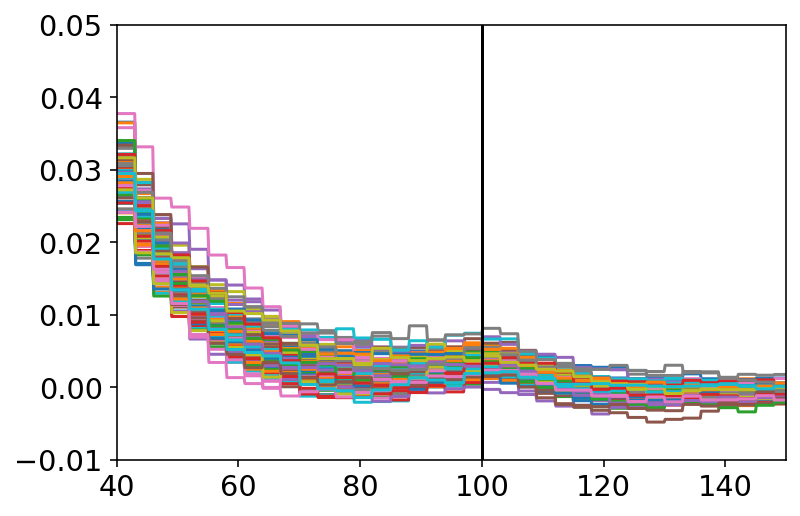

In [7]:
plt.figure()
for i in range(len(rs)):
    r = rs[i]
    xi = xis[i]
    plt.plot(r, xi)
plt.xlim(40, 150)
plt.ylim(-0.01, 0.05)
plt.axvline(r_max_true, color='k', label='true')

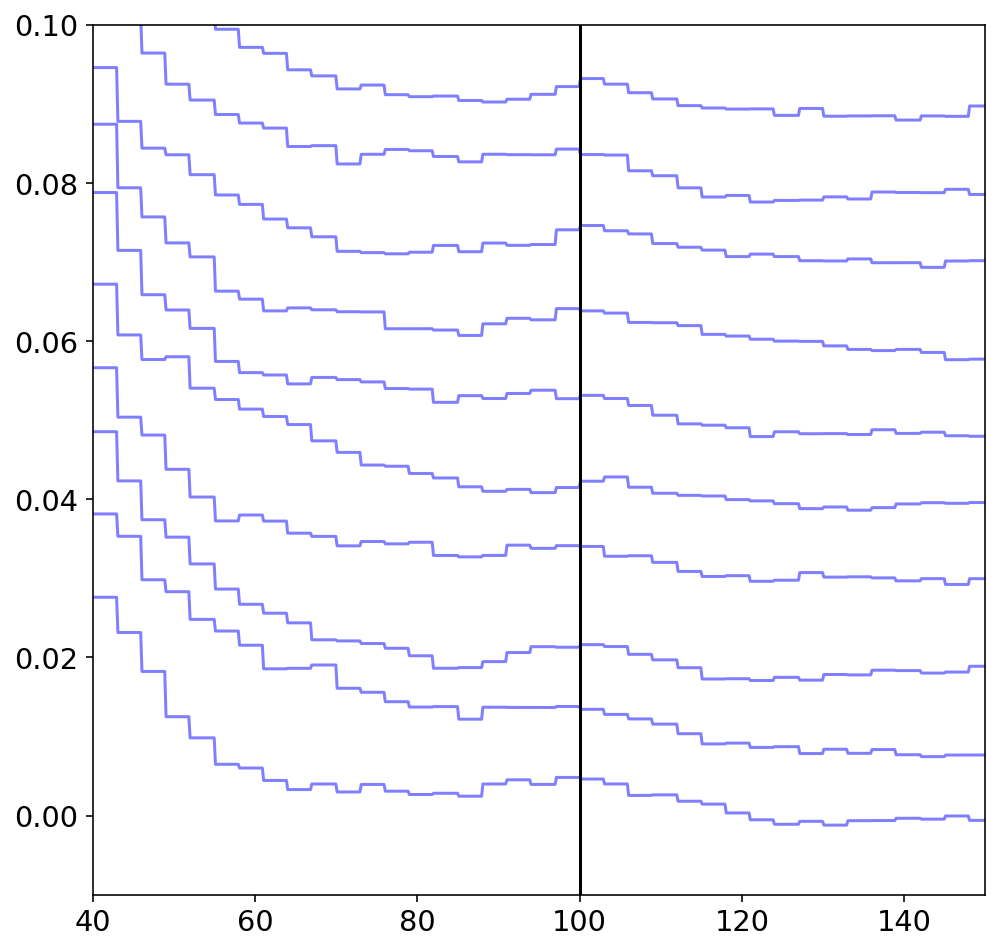

In [8]:
plt.figure(figsize=(8,8))
offset = 0
N = 10
for i in range(N):
    r = rs[i]
    xi = xis[i]
    plt.plot(r, xi+i*0.01, alpha=0.5, color='blue')

plt.xlim(40, 150)
plt.ylim(-0.01, N/100.)
plt.axvline(r_max_true, color='k', label='true')



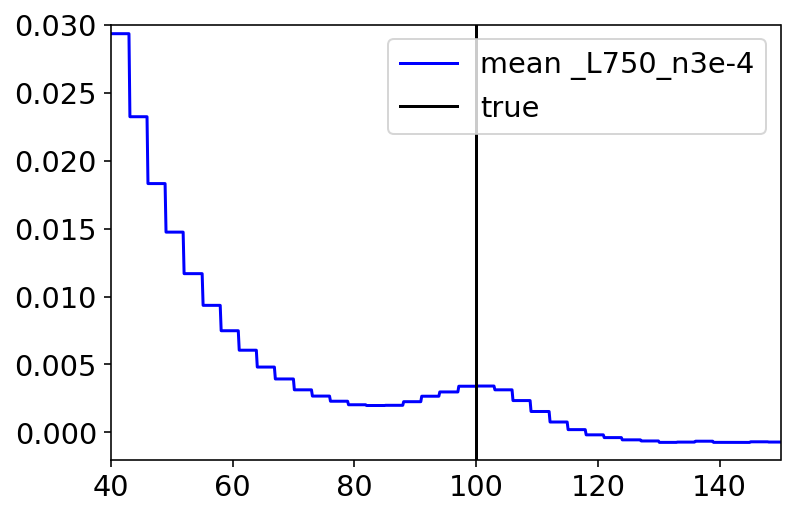

In [9]:
plt.figure()
plt.plot(r, np.mean(xis, axis=0), color='blue', label=f'mean {cat_tag}')
plt.axvline(r_max_true, color='k', label='true')
plt.xlim(40, 150)
plt.ylim(-0.002, 0.03)
plt.legend()

### Helper functions

In [10]:
# deriv: 2ax + b = 0
# x = -b/(2a)
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [11]:
def plot_histogram(r_peak_arr, labels=None, colors=None):
    if labels is None:
        labels = [None]*len(r_peak_arr)
    if colors is None:
        colors = [None]*len(r_peak_arr)
    
    plt.figure(figsize=(10,6))
    for i, r_peaks in enumerate(r_peak_arr):
        med = np.nanmedian(r_peaks)
        plt.hist(r_peaks, bins=14, histtype='step', label=labels[i], color=colors[i])
        
        if i==0:
            medlabel = 'median'
            meanlabel = 'mean'
        else:
            medlabel = None
            meanlabel = None
        
        plt.axvline(np.nanmedian(r_peaks), lw=2, color=colors[i], ls=':', label=medlabel)
        plt.axvline(np.nanmean(r_peaks), lw=2, color=colors[i], ls='-', label=meanlabel)
        
        
        std = np.nanstd(r_peaks)
        plt.axvspan(med-std, med+std, color=colors[i], alpha=0.15)
        plt.axvline(med-std, lw=0.5, color=colors[i], ls='-')
        plt.axvline(med+std, lw=0.5, color=colors[i], ls='-')
        
    plt.legend()
    plt.axvline(r_max_true, color='k', label='true', lw=1.0)
    #plt.xlim(90,110)
    
    plt.xlabel(r"r$_{\mathrm{peak}}$ ($h^{-1}$ Mpc)")
    plt.ylabel("counts")
    return plt.gca()

### Find peaks: max method
First find max value in peak region; use bins right and left of the max bin to fit a parabola.

If the max is at one of the edges (just sloping up or down), assign a NaN.

In [12]:
def find_peaks_max(r_arr, xi_arr, bw, n_points=3, region=(85,115), show_bad=False):
    xi_arr = np.array(xi_arr)
    if len(xi_arr.shape)<3:
        r_arr = [r_arr]
        xi_arr = [xi_arr]
    ntags = np.array(xi_arr).shape[0]
    N = np.array(xi_arr).shape[1]
    
    r_peak_arr = []
    for i in range(ntags):
        if show_bad:
            plt.figure()

        rs = r_arr[i]
        xis = xi_arr[i]
        
        n_nans = 0
        n_botedge = 0
        n_topedge = 0     
        
        r_peaks = []
        for j in range(N):
            r = rs[j]
            xi = xis[j]

            xi_func = interp1d(r, xi, kind='cubic')

            r_edges = np.arange(min(r), max(r)+bw, bw)
            r_avg = 0.5*(r_edges[:-1] + r_edges[1:])
            
            peak_region = np.array([(rr, xi_func(rr)) for rr in r_avg if region[0]<rr<region[1]])
            i_max = np.argmax(peak_region[:,1])
            r_max = peak_region[i_max][0]
            bad_imaxes = [0, len(peak_region)-1]
            if i_max in bad_imaxes:
                r_peaks.append(np.NaN)
                n_nans += 1
                if show_bad:
                    plt.plot(r, xi)
                continue
            
            if n_points==3:
                i_maxes = [i_max-1, i_max, i_max+1]
                r_points, xi_points = peak_region[i_maxes].T
            elif n_points==5:
                i_maxes = [i_max-2, i_max-1, i_max, i_max+1, i_max+2]
                i_maxes = [im for im in i_maxes if im>=0 and im<len(peak_region)]
                r_points, xi_points = peak_region[i_maxes].T
                
            popt, _ = curve_fit(quadratic, r_points, xi_points)
            a, b, c = popt

            r_peak = -b/(2*a)
            if r_peak<region[0]:
                r_peak=region[0]
                n_botedge += 1
            elif r_peak>region[1]:
                r_peak=region[1]
                n_topedge += 1
            r_peaks.append(r_peak)
#             if r_peak<region[0] or r_peak>region[1]:
#                 r_peaks.append(np.NaN)
#             else:
#                 r_peaks.append(r_peak)

        r_peak_arr.append(r_peaks)
        
        print('Number of NaNs:', n_nans, ', Bottom edges:', n_botedge, ', Top edges:', n_topedge)
        
    return r_peak_arr, r_points, xi_points, popt

### Find peaks: guess center

In [13]:
def find_peaks_center(r_arr, xi_arr, rpeak_guess, bw, n_points=3, region=(85,115)):
    xi_arr = np.array(xi_arr)
    if len(xi_arr.shape)<3:
        r_arr = [r_arr]
        xi_arr = [xi_arr]
        
    ntags = np.array(xi_arr).shape[0]
    N = np.array(xi_arr).shape[1]

    r_peak_arr = np.zeros((ntags, N))
    for i in range(ntags):
        plt.figure()

        rs = r_arr[i]
        xis = xi_arr[i]
        
        n_nans = 0
        n_botedge = 0
        n_topedge = 0
        #r_maxes = []
        #r_peaks = []
        for j in range(N):
            r = rs[j]
            xi = xis[j]

            xi_func = interp1d(r, xi, kind='cubic')

            if n_points==3:
                r_points = [rpeak_guess-bw, rpeak_guess, rpeak_guess+bw]
            elif n_points==5:
                r_points = [rpeak_guess-2*bw, rpeak_guess-bw, rpeak_guess, rpeak_guess+bw, rpeak_guess+2*bw]
                
            xi_points = [xi_func(rp) for rp in r_points]
            popt, _ = curve_fit(quadratic, r_points, xi_points)
            a, b, c = popt

            if a>0:
                r_peak_arr[i][j] = np.NaN
                n_nans += 1
                continue

            r_peak = -b/(2*a)
            if r_peak<region[0]:
                r_peak=region[0]
                n_botedge +=1
            elif r_peak>region[1]:
                r_peak=region[1]
                n_topedge += 1
            r_peak_arr[i][j] = r_peak
#             if r_peak<region[0] or r_peak>region[1]:
#                 r_peak = np.NaN
#                 n_nans += 1
            r_peak_arr[i][j] = r_peak 
        #r_peak_arr.append(np.array(r_peaks))
        
        print('Number of NaNs:', n_nans, ', Bottom edges:', n_botedge, ', Top edges:', n_topedge)
        
    return r_peak_arr, r_points, xi_points, popt

## Check out what these methods are doing

In [14]:
cat_tag = '_L750_n3e-4'
cf_tag = '_tophat_bw3'
bw=3

rpeak_guess = 102

Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(-0.002, 0.01)

<Figure size 432x288 with 0 Axes>

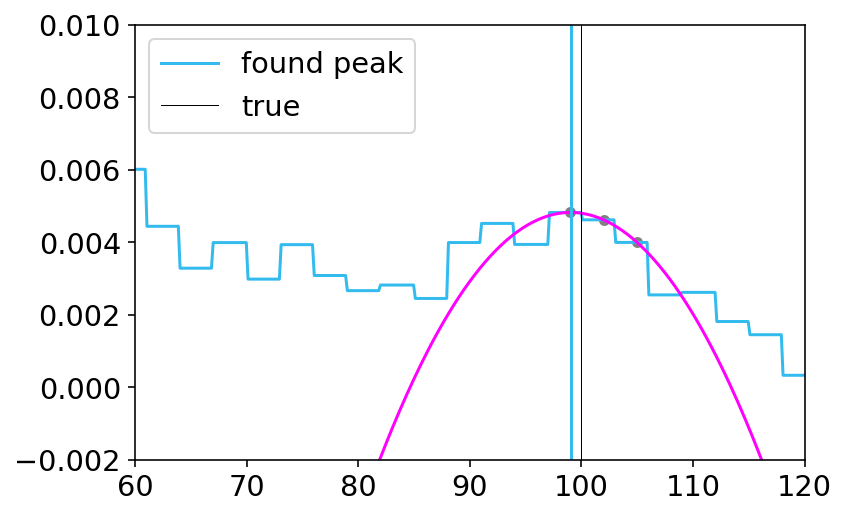

In [15]:
n = 0
color = ctopmany
rs, xis = load_data(cat_tag, cf_tag)
rn = rs[n]
xin = xis[n]
r_peak_arr, r_points, xi_points, popt = find_peaks_center([rn], [xin], rpeak_guess, bw=bw, n_points=3)

plt.figure()
plt.plot(rn, xin, color=color)
plt.plot(rn, quadratic(rn, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_peak_arr[0], color=color, label='found peak')
plt.axvline(r_max_true, color='k', lw=0.5, label='true')
plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0


(-0.002, 0.01)

<Figure size 432x288 with 0 Axes>

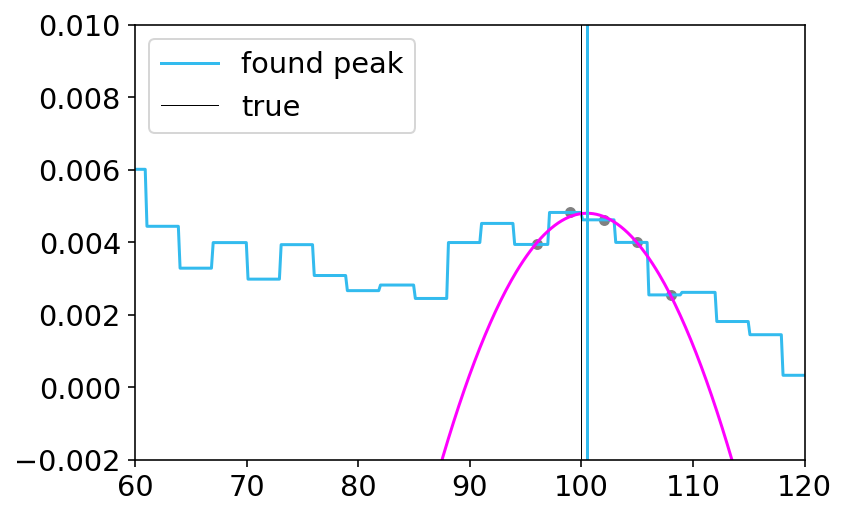

In [16]:
n = 0
color = ctopmany
rs, xis = load_data(cat_tag, cf_tag)
rn = rs[n]
xin = xis[n]
r_peak_arr, r_points, xi_points, popt = find_peaks_center([rn], [xin], rpeak_guess, bw=bw, n_points=5)

plt.figure()
plt.plot(rn, xin, color=color)
plt.plot(rn, quadratic(rn, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_peak_arr[0], color=color, label='found peak')
plt.axvline(r_max_true, color='k', lw=0.5, label='true')
plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0
[[99.43766165706414]]


(-0.002, 0.01)

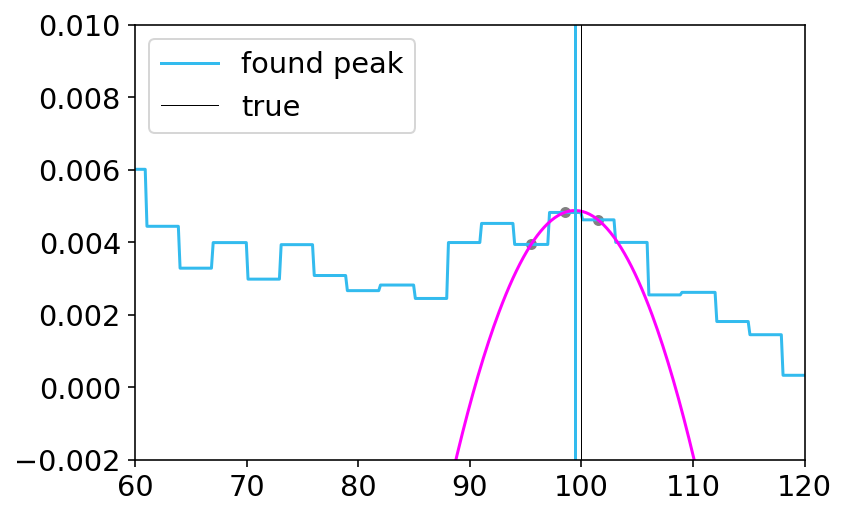

In [17]:
n = 0
color = ctopmany
rs, xis = load_data(cat_tag, cf_tag)
rn = rs[n]
xin = xis[n]

r_peak_arr, r_points, xi_points, popt = find_peaks_max([rn], [xin], bw, n_points=3)
print(r_peak_arr)
plt.figure()
plt.plot(rn, xin, color=color)
plt.plot(rn, quadratic(rn, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_peak_arr[0], color=color, label='found peak')
plt.axvline(r_max_true, color='k', lw=0.5, label='true')
plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0


(-0.002, 0.01)

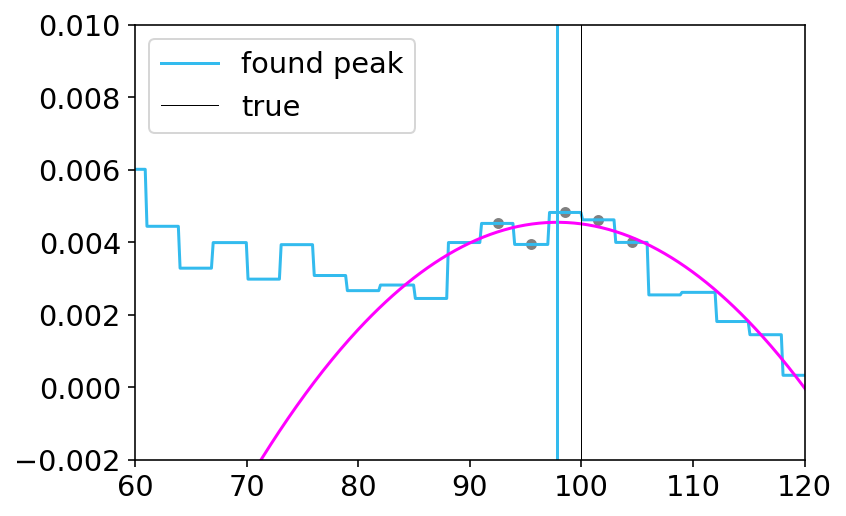

In [18]:
n = 0
color = ctopmany
rs, xis = load_data(cat_tag, cf_tag)
rn = rs[n]
xin = xis[n]

r_peak_arr, r_points, xi_points, popt = find_peaks_max([rn], [xin], bw, n_points=5)

plt.figure()
plt.plot(rn, xin, color=color)
plt.plot(rn, quadratic(rn, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_peak_arr[0], color=color, label='found peak')
plt.axvline(r_max_true, color='k', lw=0.5, label='true')
plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

## Density 3e-4, bin width 3

In [19]:
colors = [ctopmany, cspline, cbao]

In [20]:
cat_tag = '_L750_n3e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12', f'_baoiter_cosmob17']
labels = [ct[1:] for ct in cf_tags]
bw=3

r_arr = []
xi_arr = []
for i, cf_tag in enumerate(cf_tags):
    rs, xis = load_data(cat_tag, cf_tag)
    r_arr.append(rs)
    xi_arr.append(xis)

Peaks center guess

Number of NaNs: 27 , Bottom edges: 1 , Top edges: 4
Number of NaNs: 0 , Bottom edges: 1 , Top edges: 0
Number of NaNs: 3 , Bottom edges: 2 , Top edges: 5


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

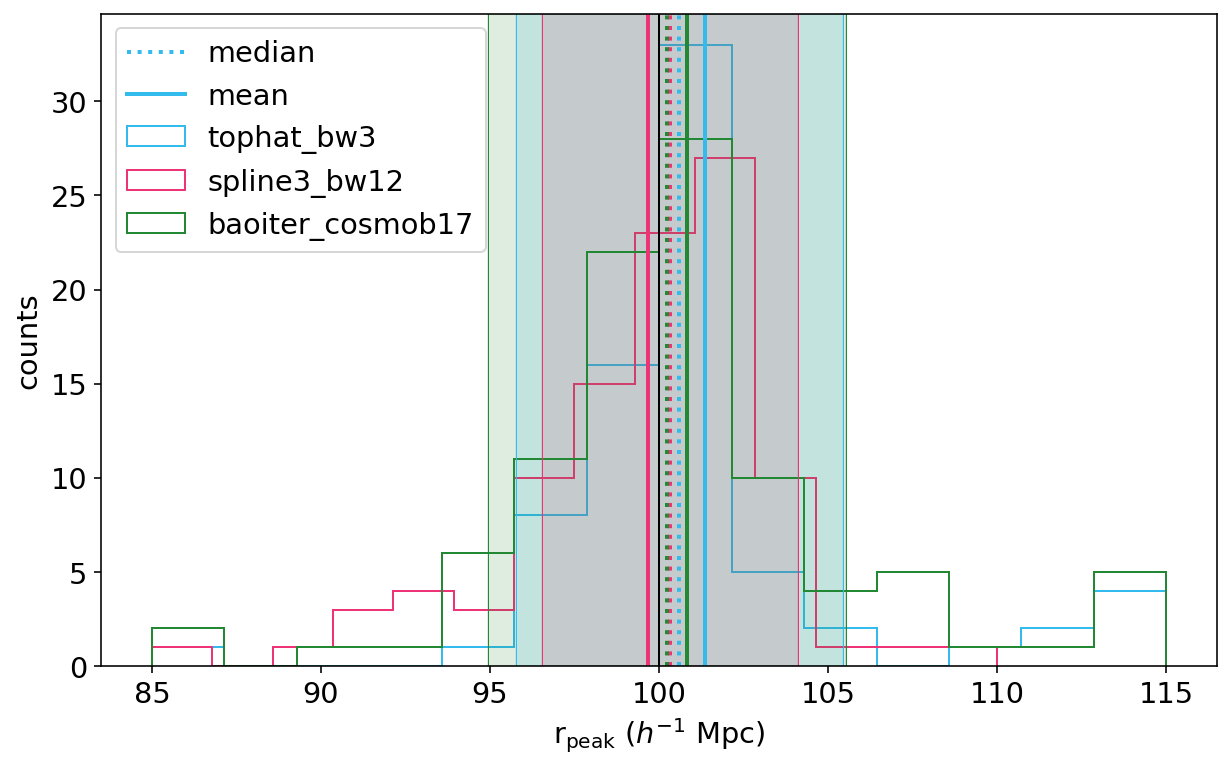

In [21]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 7 , Bottom edges: 1 , Top edges: 0
Number of NaNs: 0 , Bottom edges: 1 , Top edges: 0
Number of NaNs: 3 , Bottom edges: 2 , Top edges: 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

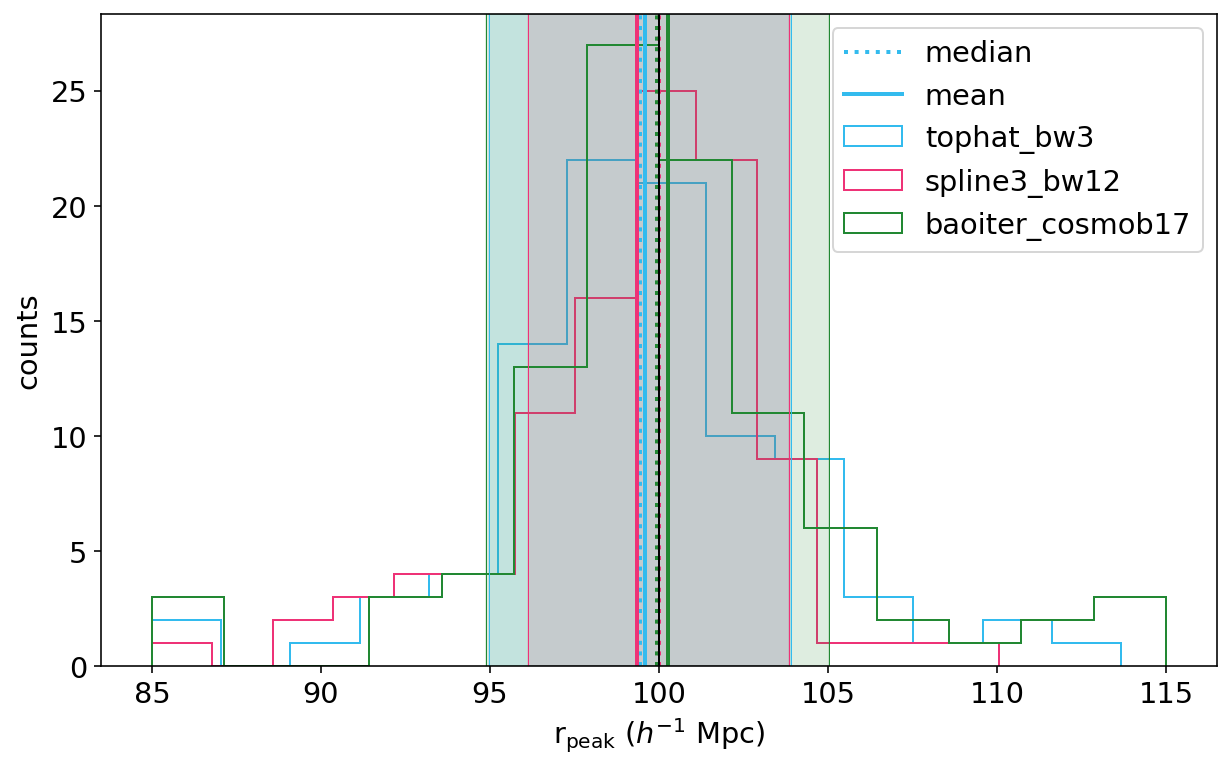

In [22]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Peaks rmax

Number of NaNs: 4 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 7 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 6 , Bottom edges: 0 , Top edges: 0


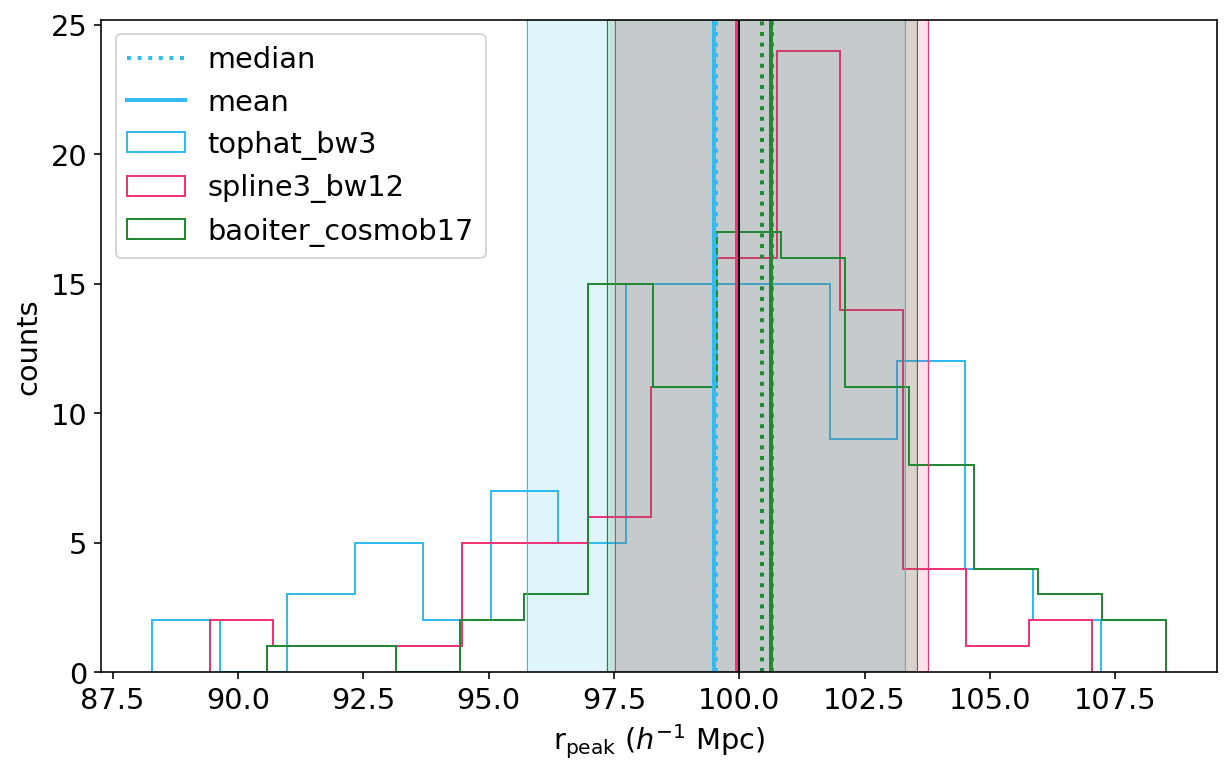

In [23]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 4 , Bottom edges: 1 , Top edges: 3
Number of NaNs: 7 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 6 , Bottom edges: 0 , Top edges: 0


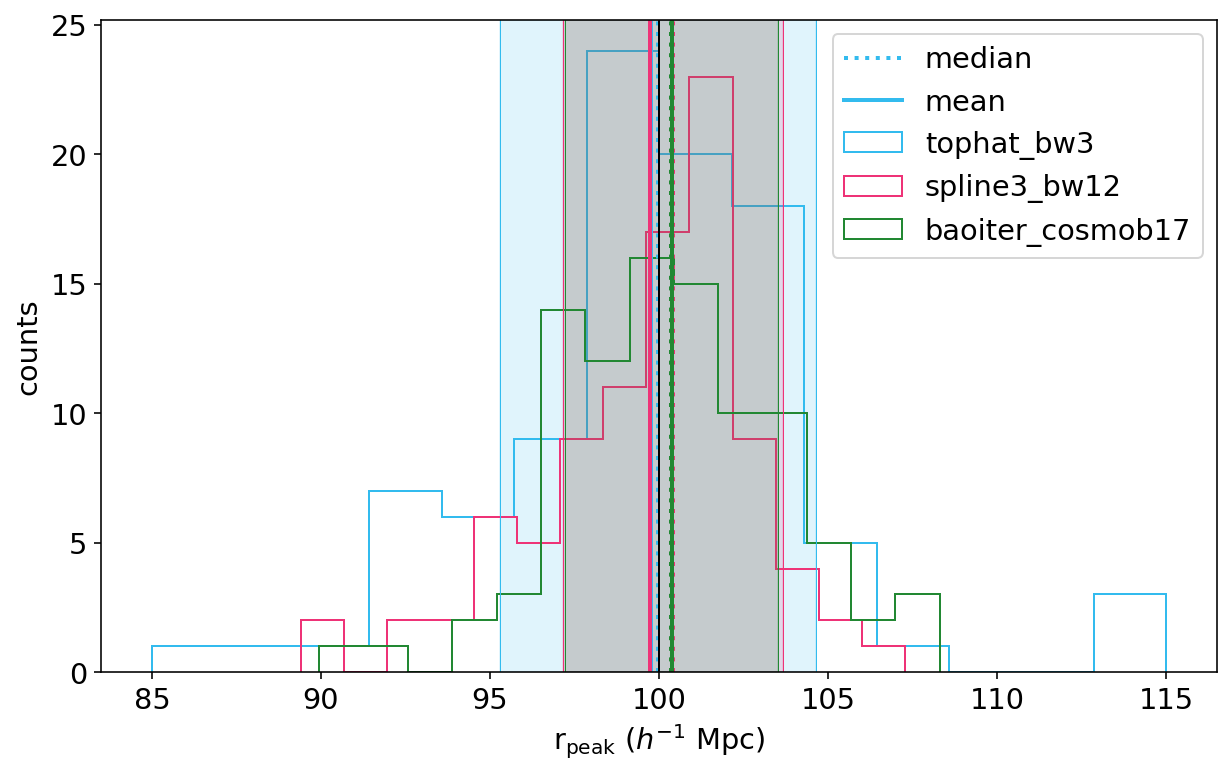

In [24]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

## Density 3e-4, bin width 6

In [25]:
cat_tag = '_L750_n3e-4'
cf_tags = ['_tophat_bw6', '_spline3_bw12', f'_baoiter_cosmob17']
labels = [ct[1:] for ct in cf_tags]
bw=6
r_edges = np.arange(min(r), max(r)+bw, bw)
r_avg = 0.5*(r_edges[:-1] + r_edges[1:])

r_arr = []
xi_arr = []
for i, cf_tag in enumerate(cf_tags):
    rs, xis = load_data(cat_tag, cf_tag)
    r_arr.append(rs)
    xi_arr.append(xis)

Peaks center guess

Number of NaNs: 7 , Bottom edges: 4 , Top edges: 3
Number of NaNs: 0 , Bottom edges: 1 , Top edges: 0
Number of NaNs: 3 , Bottom edges: 2 , Top edges: 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

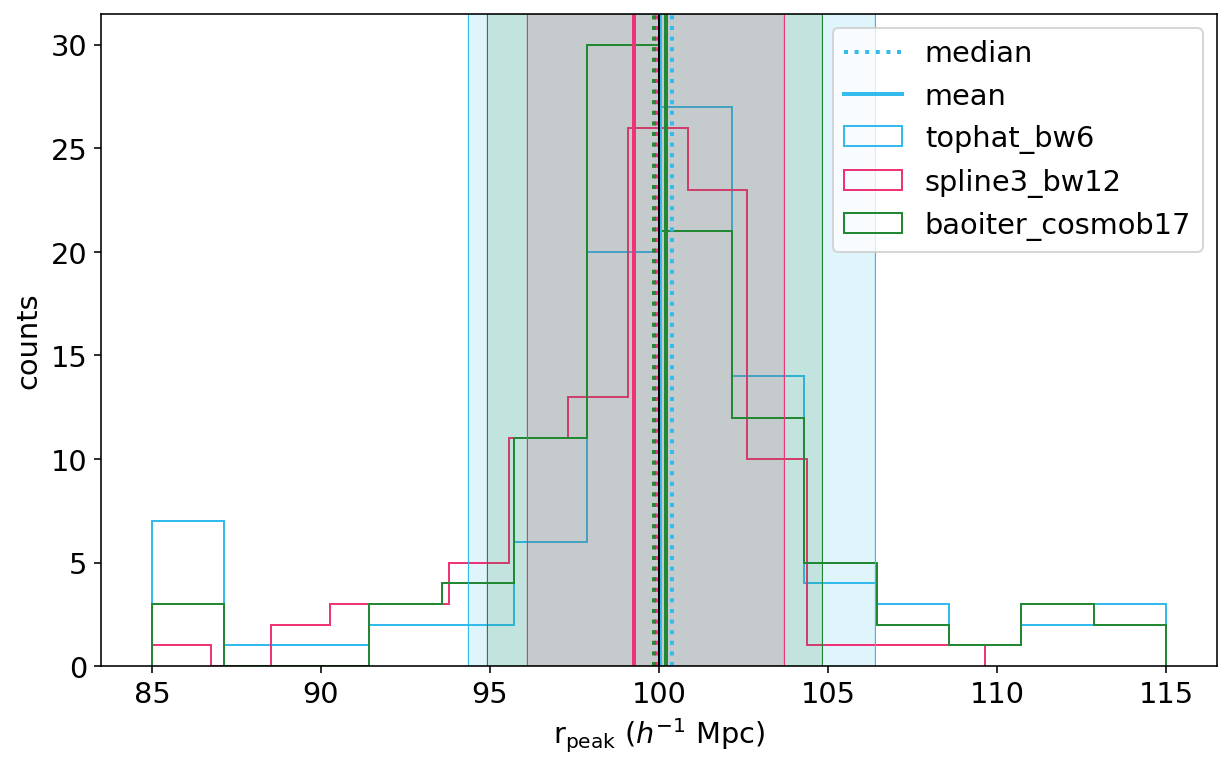

In [26]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 0 , Bottom edges: 1 , Top edges: 1
Number of NaNs: 0 , Bottom edges: 1 , Top edges: 0
Number of NaNs: 1 , Bottom edges: 4 , Top edges: 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

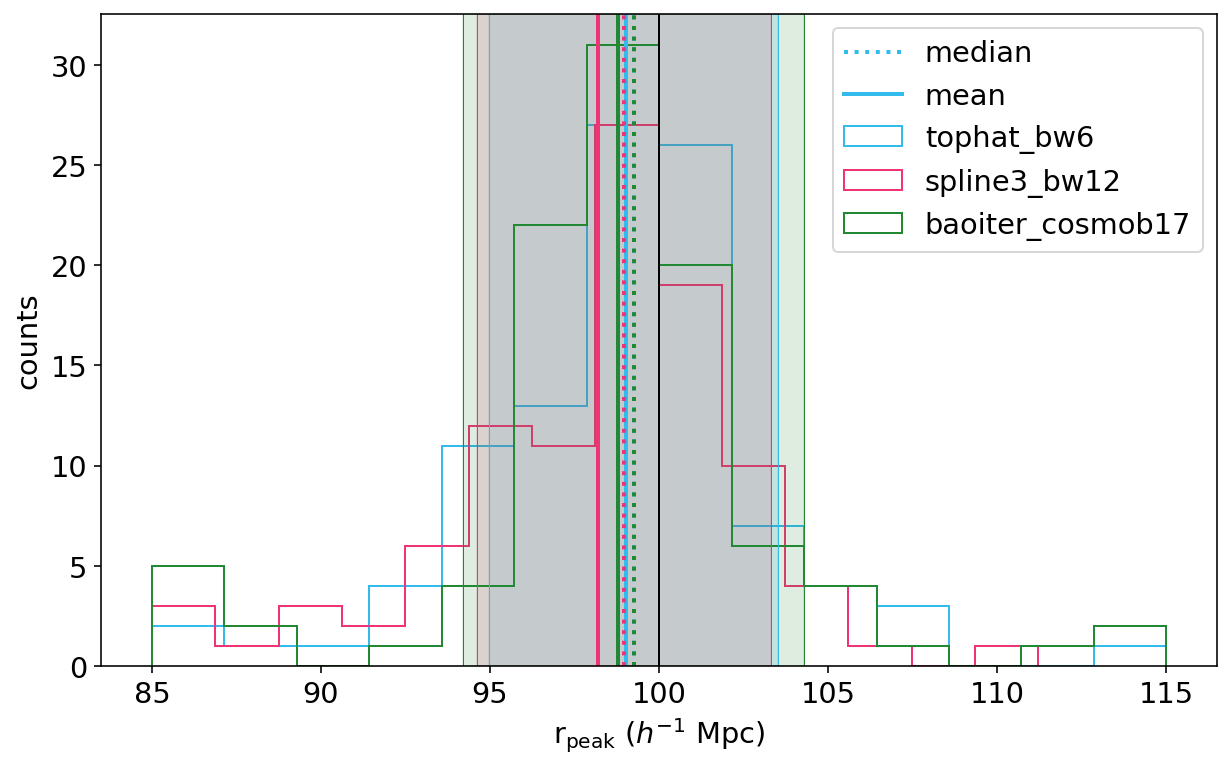

In [27]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Peaks rmax

Number of NaNs: 6 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 13 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 13 , Bottom edges: 0 , Top edges: 0


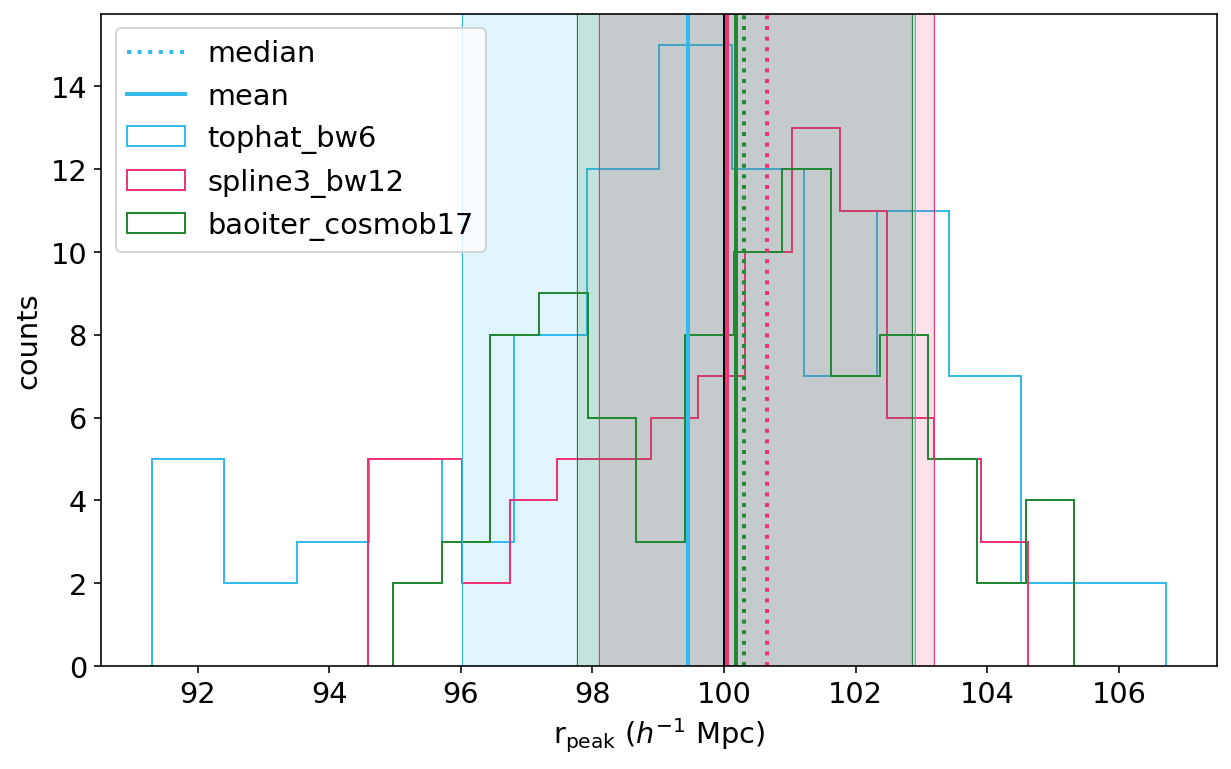

In [28]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=3)

ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 6 , Bottom edges: 1 , Top edges: 1
Number of NaNs: 13 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 13 , Bottom edges: 0 , Top edges: 0


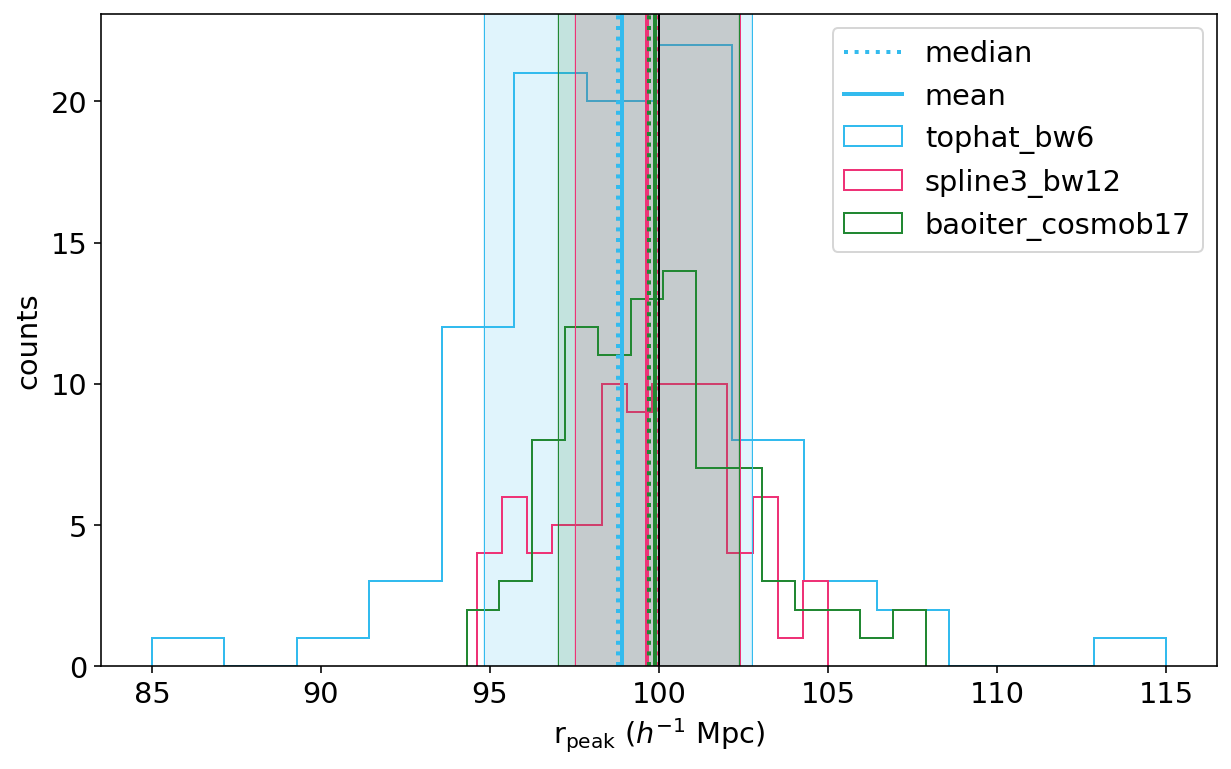

In [29]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

### Check out the 1e-4 number density mock

True r_peak: 100.0


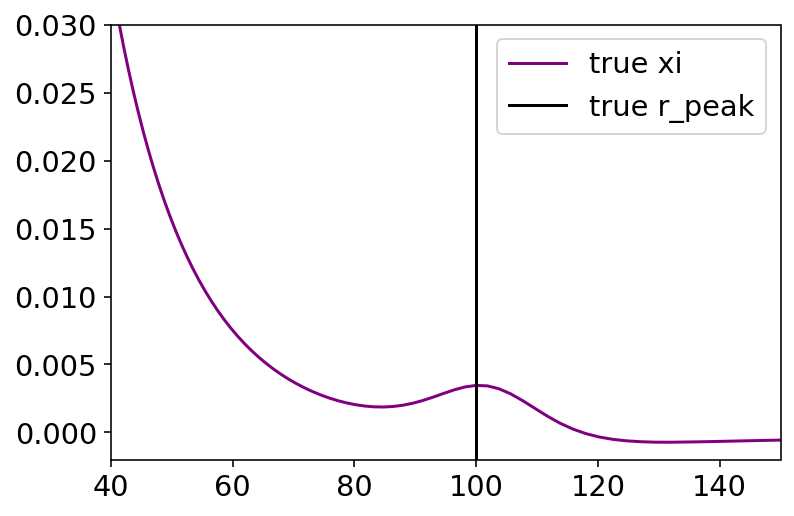

In [30]:
region = (85, 115)
cat_tag = '_L750_n1e-4'
r_true, xi_true = load_true(cat_tag)
peak_region_true = np.array([(r_true[i], xi_true[i]) for i in range(len(r_true)) if region[0]<r_true[i]<region[1]])
i_max_true = np.argmax(peak_region_true[:,1])
r_max_true = peak_region_true[i_max_true][0]
print("True r_peak:", r_max_true)

plt.figure()
plt.plot(r_true, xi_true, color='purple', label=f'true xi')
plt.axvline(r_max_true, color='k', label='true r_peak')
plt.xlim(40, 150)
plt.ylim(-0.002, 0.03)
plt.legend()

In [31]:
cat_tag = '_L750_n1e-4'
cf_tag = '_tophat_bw3'
rs, xis = load_data(cat_tag, cf_tag)

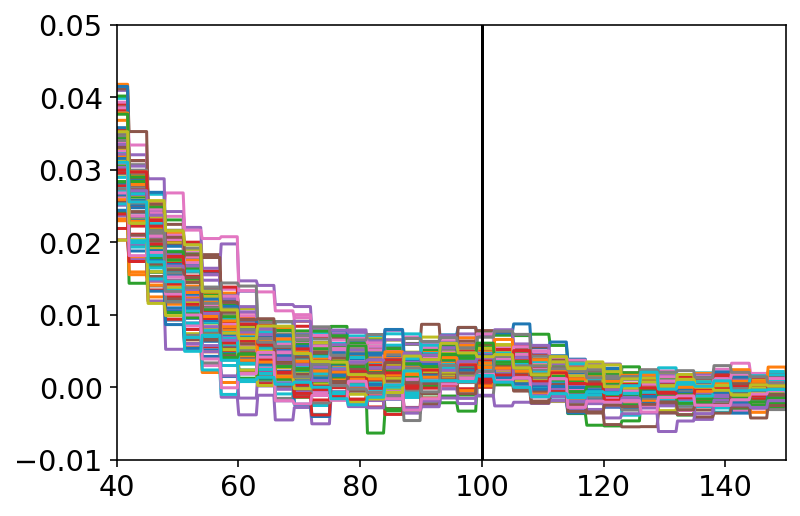

In [32]:
plt.figure()
for i in range(len(rs)):
    r = rs[i]
    xi = xis[i]
    plt.plot(r, xi)
plt.xlim(40, 150)
plt.ylim(-0.01, 0.05)
plt.axvline(r_max_true, color='k', label='true')

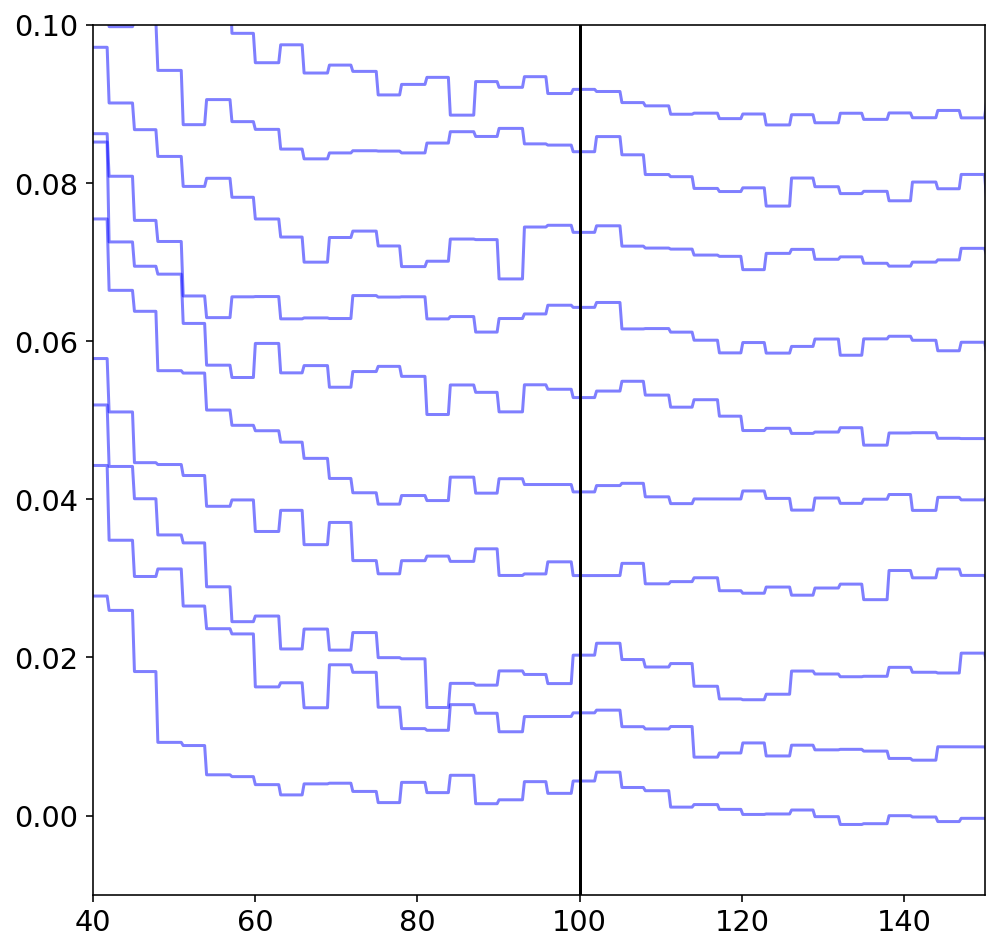

In [33]:
plt.figure(figsize=(8,8))
offset = 0
N = 10
for i in range(N):
    r = rs[i]
    xi = xis[i]
    plt.plot(r, xi+i*0.01, alpha=0.5, color='blue')

plt.xlim(40, 150)
plt.ylim(-0.01, N/100.)
plt.axvline(r_max_true, color='k', label='true')

## Density 1e-4, bin width 3

In [34]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12', f'_baoiter_cosmob17']
labels = [ct[1:] for ct in cf_tags]
bw=3
r_edges = np.arange(min(r), max(r)+bw, bw)
r_avg = 0.5*(r_edges[:-1] + r_edges[1:])

r_arr = []
xi_arr = []
for i, cf_tag in enumerate(cf_tags):
    rs, xis = load_data(cat_tag, cf_tag)
    r_arr.append(rs)
    xi_arr.append(xis)

Peak guess center

Number of NaNs: 49 , Bottom edges: 0 , Top edges: 1
Number of NaNs: 3 , Bottom edges: 4 , Top edges: 2
Number of NaNs: 5 , Bottom edges: 3 , Top edges: 5


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

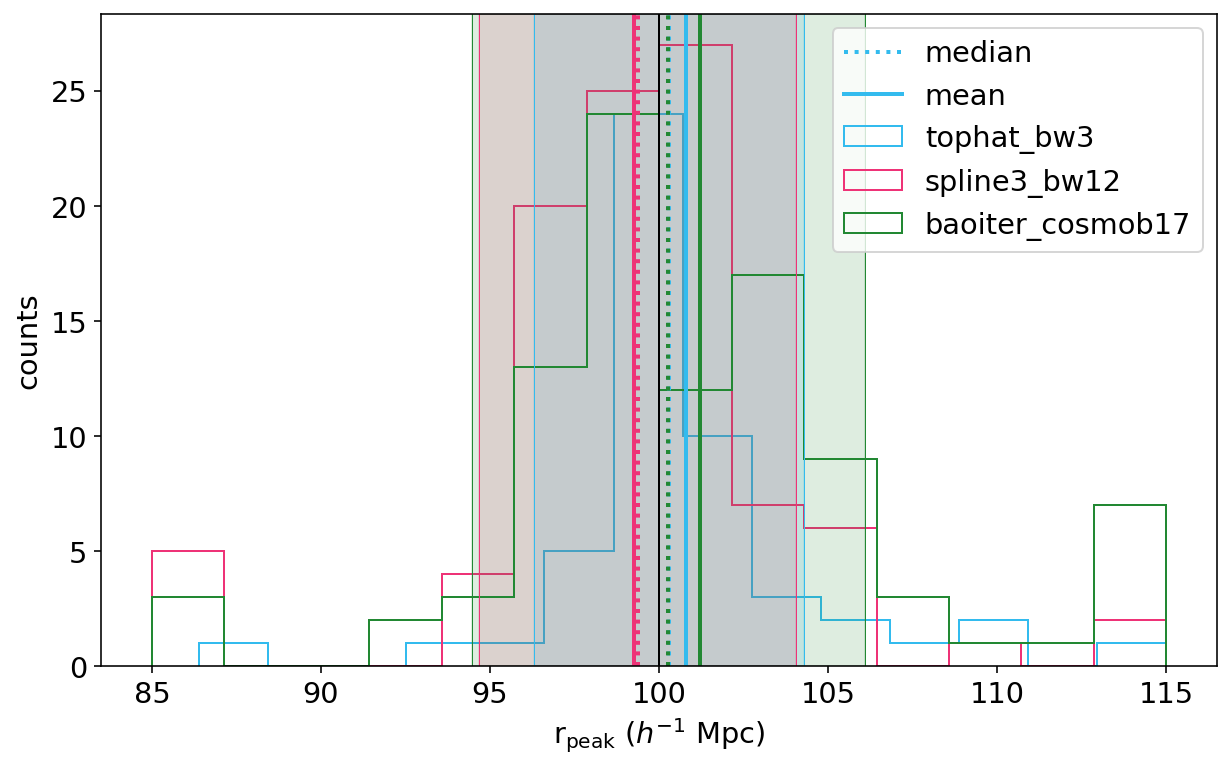

In [35]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 31 , Bottom edges: 1 , Top edges: 2
Number of NaNs: 3 , Bottom edges: 4 , Top edges: 2
Number of NaNs: 5 , Bottom edges: 3 , Top edges: 4


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

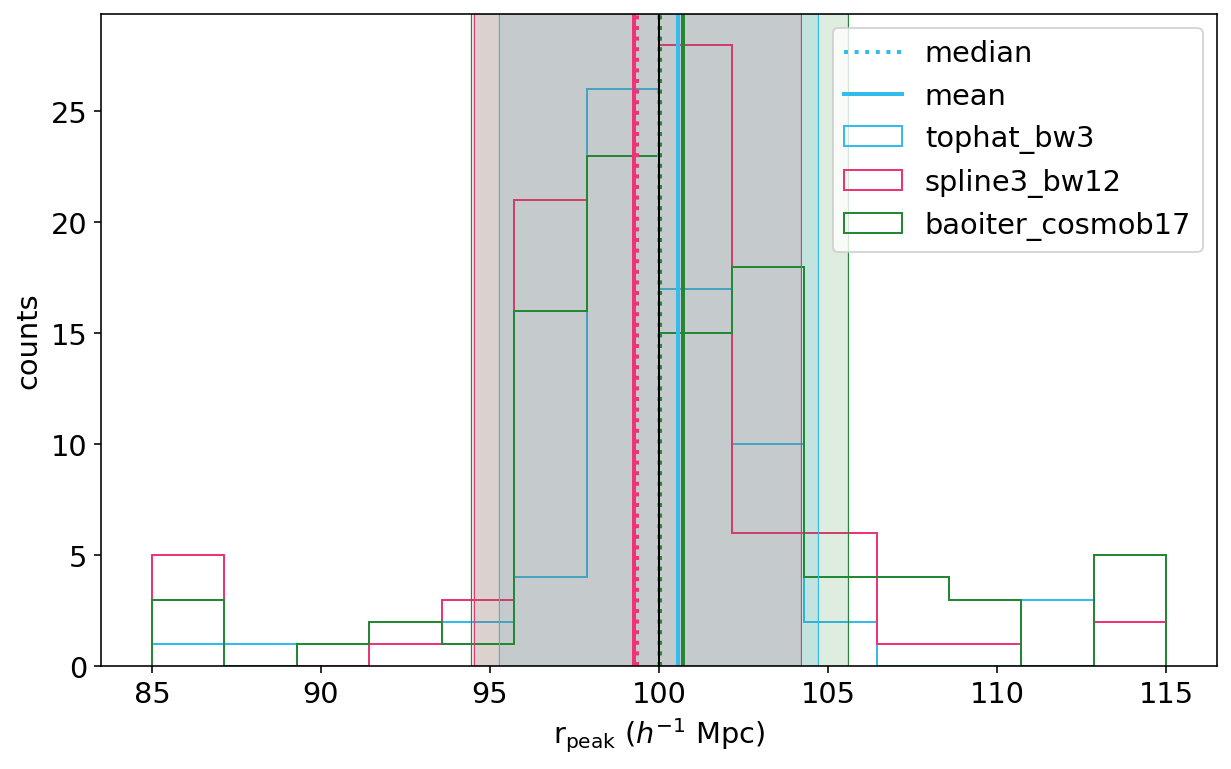

In [36]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Peaks rmax

Number of NaNs: 10 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 9 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 10 , Bottom edges: 0 , Top edges: 0


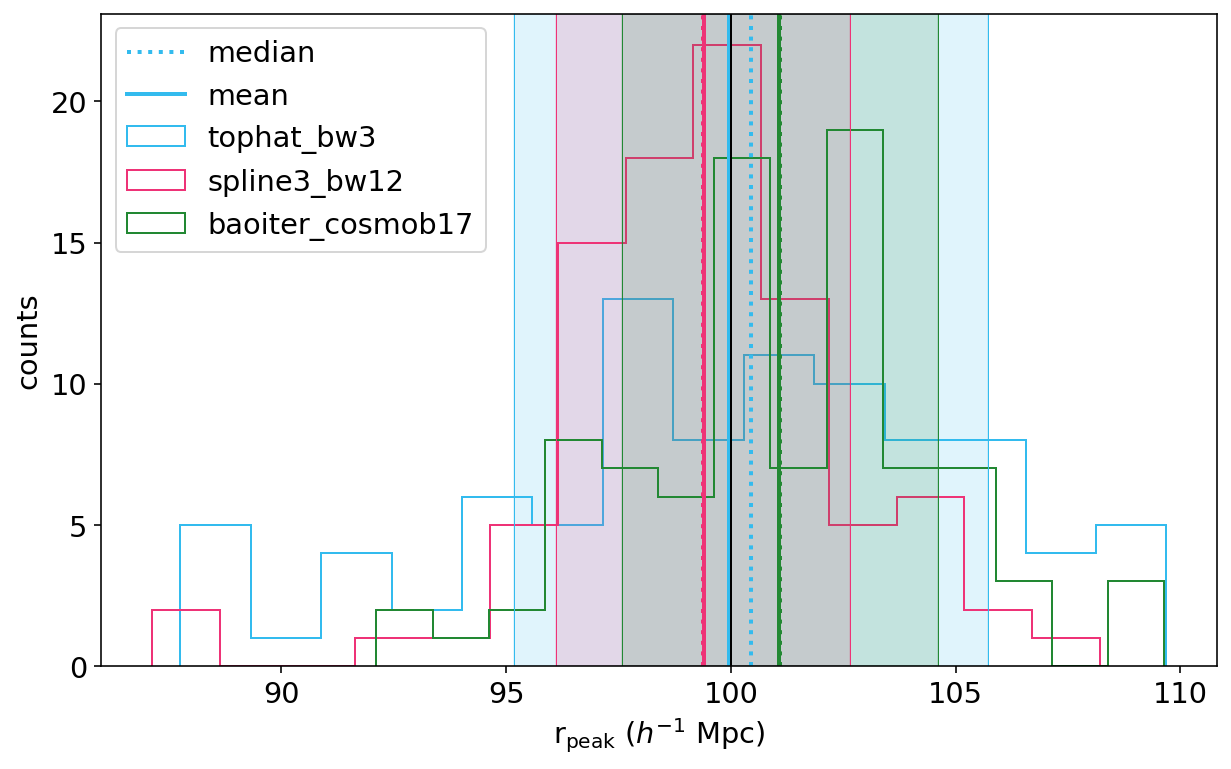

In [37]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 10 , Bottom edges: 1 , Top edges: 1
Number of NaNs: 9 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 10 , Bottom edges: 0 , Top edges: 0


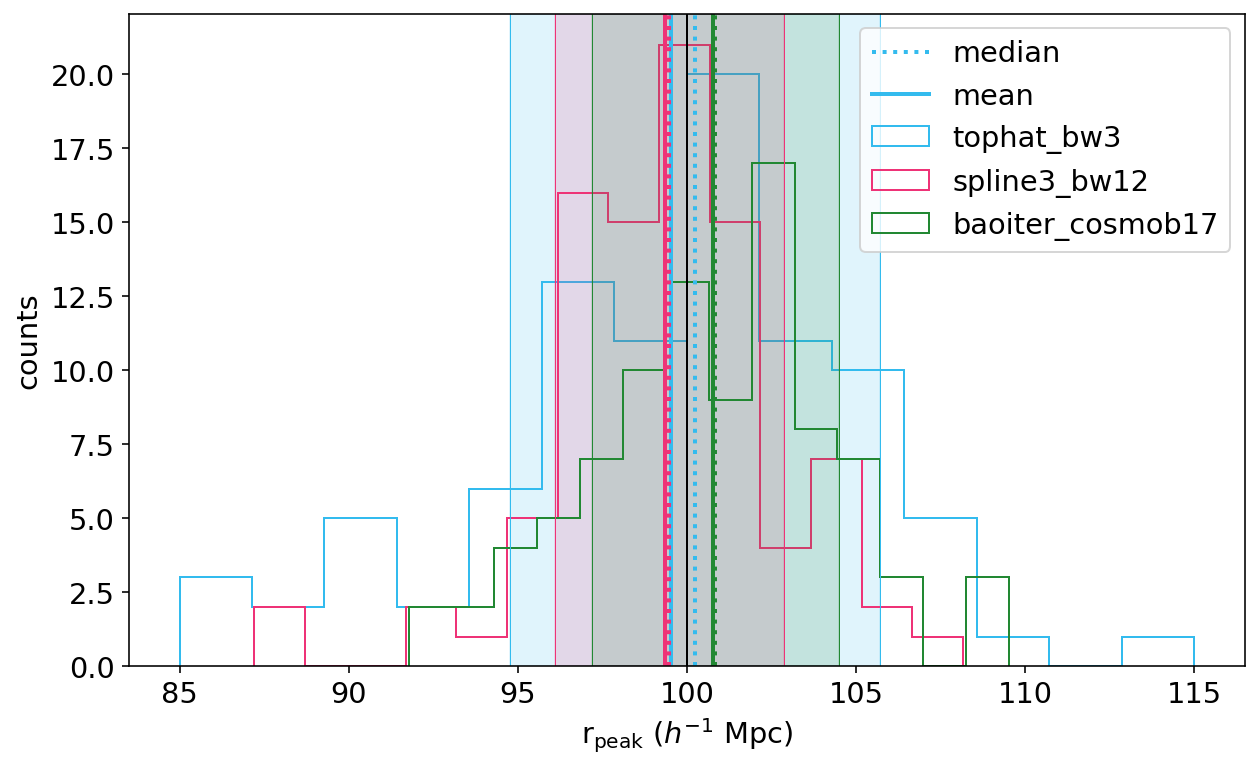

In [38]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

## Density 1e-4, bin width 6

In [39]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw6', '_spline3_bw12', f'_baoiter_cosmob17']
labels = [ct[1:] for ct in cf_tags]
bw=6
r_edges = np.arange(min(r), max(r)+bw, bw)
r_avg = 0.5*(r_edges[:-1] + r_edges[1:])

r_arr = []
xi_arr = []
for i, cf_tag in enumerate(cf_tags):
    rs, xis = load_data(cat_tag, cf_tag)
    r_arr.append(rs)
    xi_arr.append(xis)

Peak guess center

Number of NaNs: 22 , Bottom edges: 2 , Top edges: 2
Number of NaNs: 3 , Bottom edges: 4 , Top edges: 2
Number of NaNs: 5 , Bottom edges: 3 , Top edges: 4


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

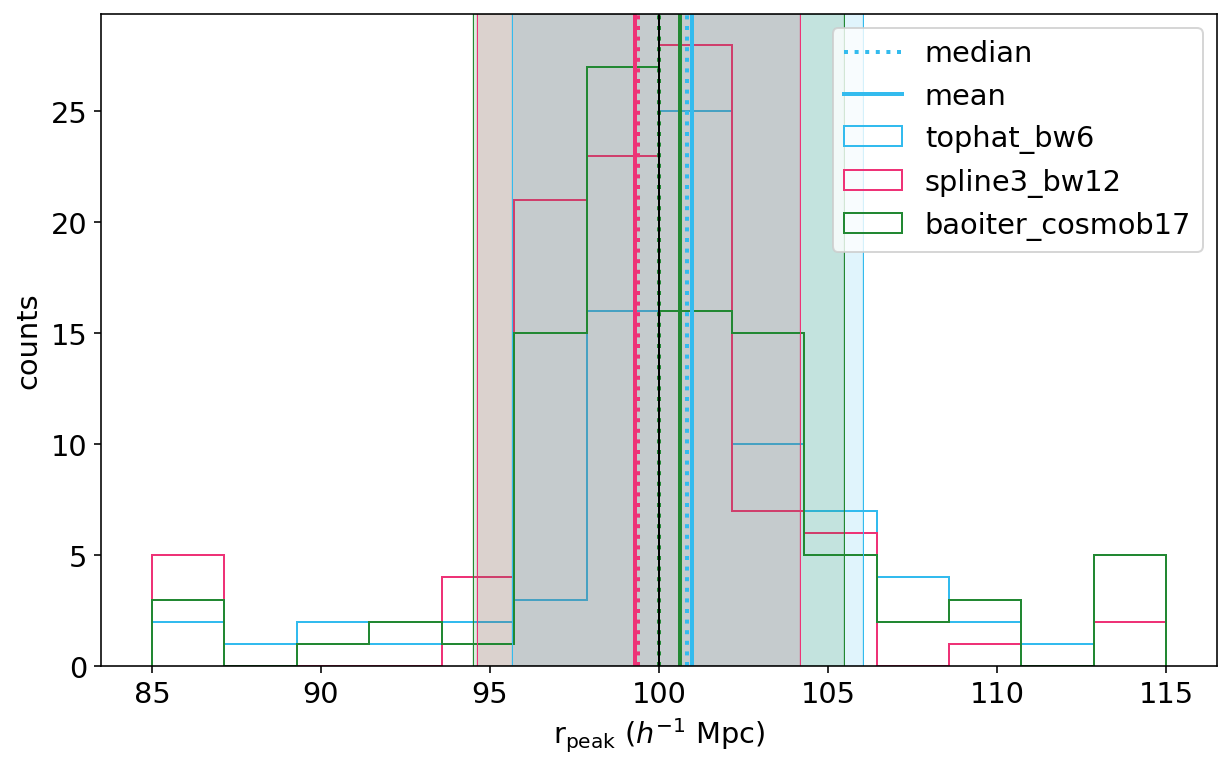

In [40]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 8 , Bottom edges: 5 , Top edges: 3
Number of NaNs: 3 , Bottom edges: 4 , Top edges: 1
Number of NaNs: 3 , Bottom edges: 3 , Top edges: 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

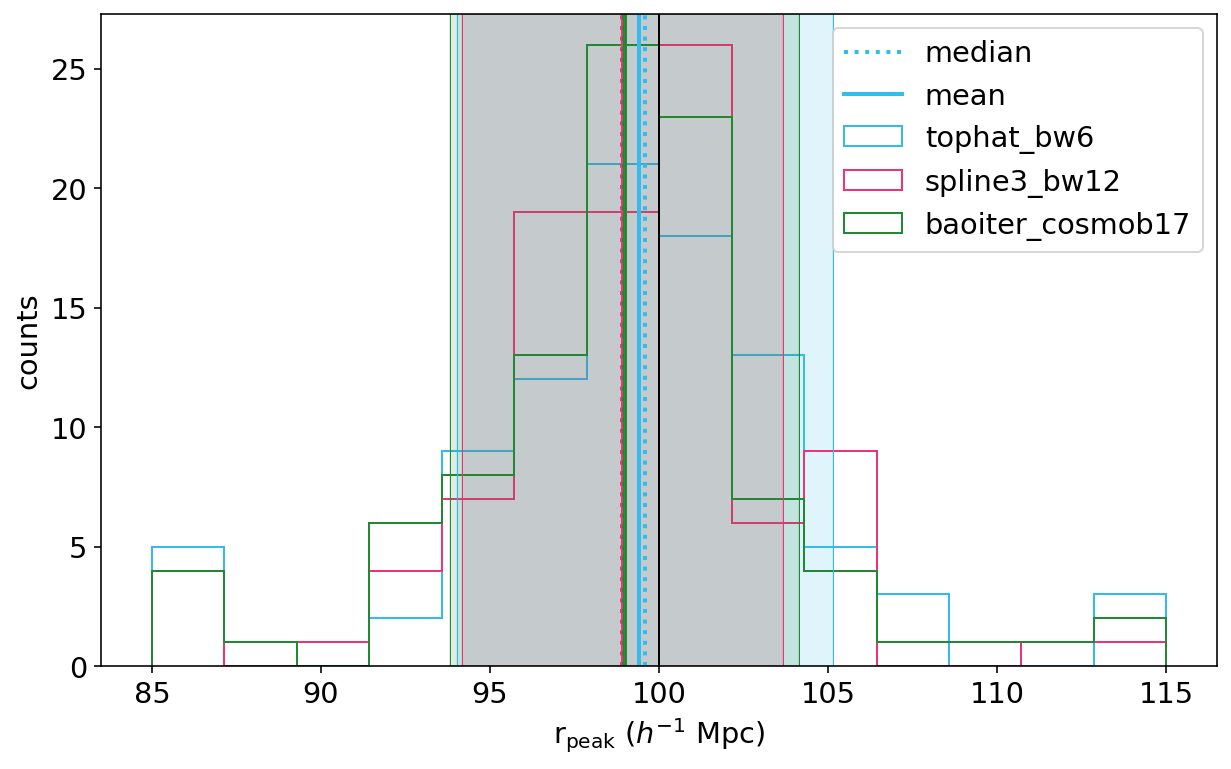

In [41]:
r_peak_arr, *_ = find_peaks_center(r_arr, xi_arr, r_max_true, bw=bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Peaks rmax

Number of NaNs: 16 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 11 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 14 , Bottom edges: 0 , Top edges: 0


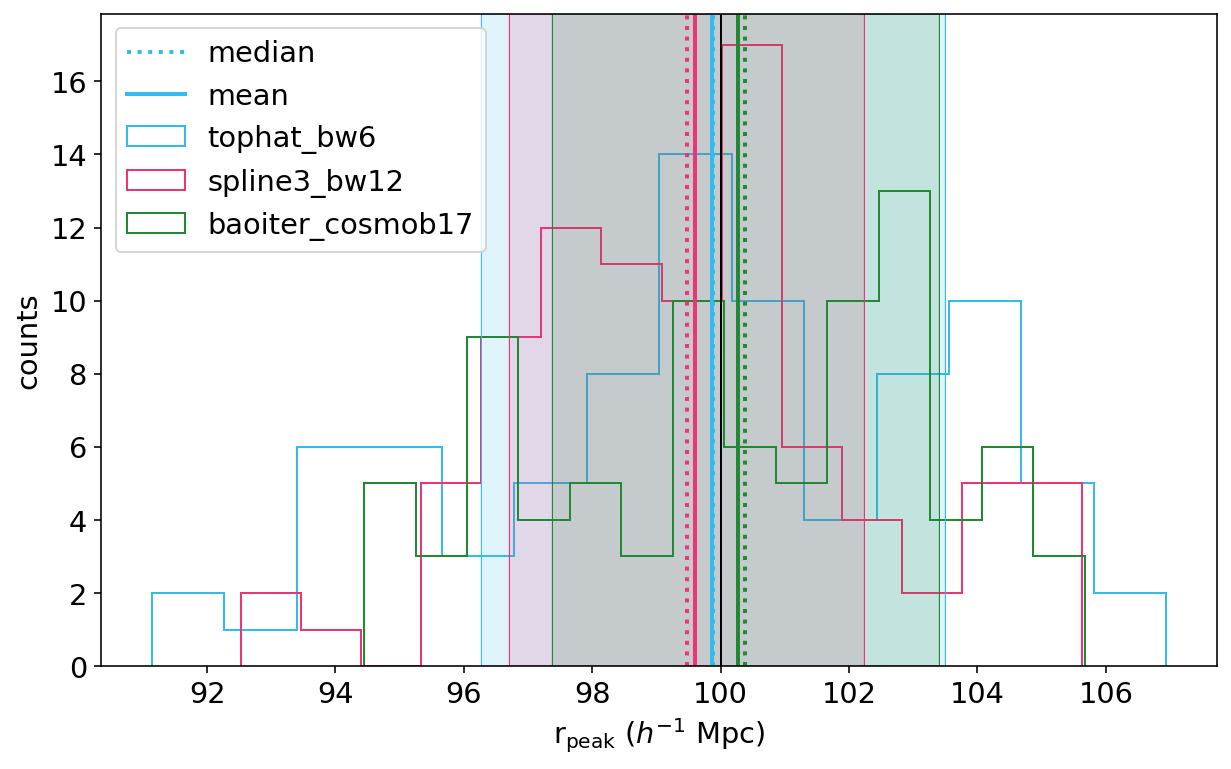

In [42]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=3)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)

Number of NaNs: 16 , Bottom edges: 0 , Top edges: 1
Number of NaNs: 11 , Bottom edges: 0 , Top edges: 0
Number of NaNs: 14 , Bottom edges: 0 , Top edges: 0


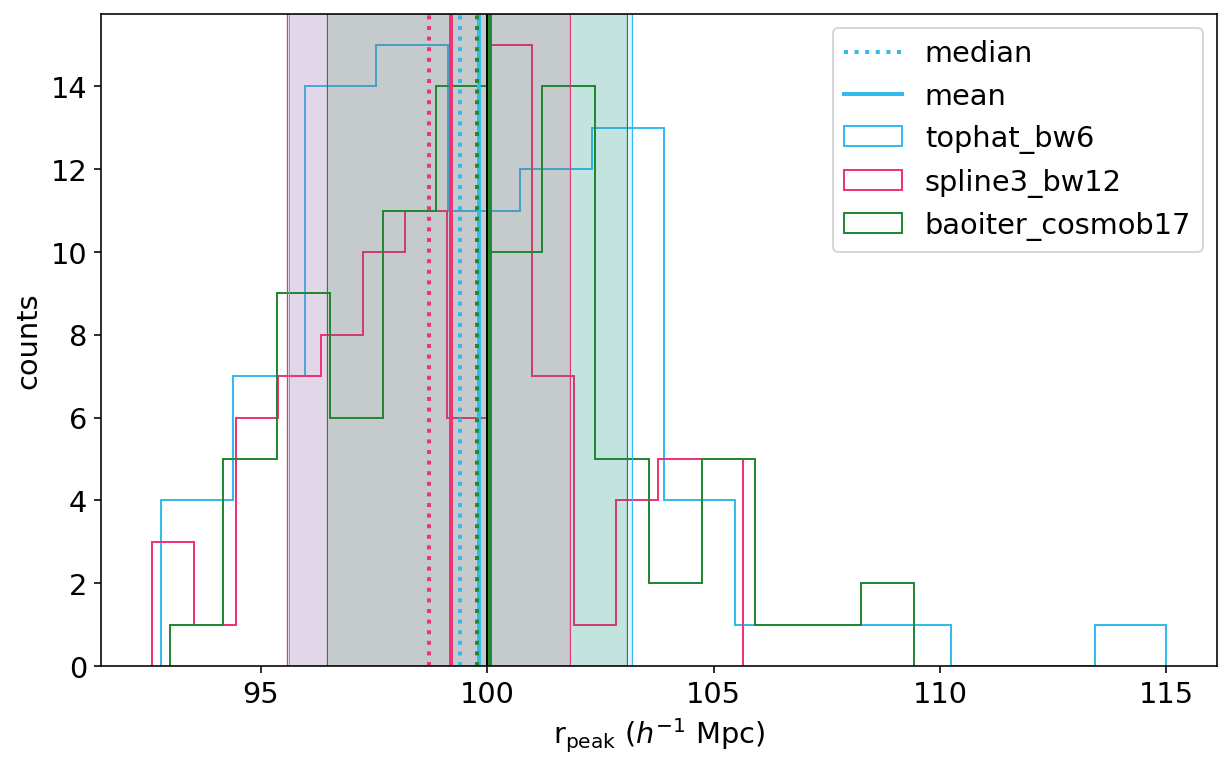

In [43]:
r_peak_arr, *_ = find_peaks_max(r_arr, xi_arr, bw, n_points=5)
ax = plot_histogram(r_peak_arr, labels=labels, colors=colors)